#PCA Visualization Eigenvalues

##Data import

In [ ]:
import os, gc
import pandas as pd
import numpy as np
# Viz
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)
plt.style.use('fivethirtyeight')
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
kmnist_train_image = np.load('kmnist-train-imgs.npz')['arr_0']
kmnist_train_label = np.load('kmnist-train-labels.npz')['arr_0']

kmnist_test_image = np.load('kmnist-test-imgs.npz')['arr_0']
kmnist_test_label = np.load('kmnist-test-labels.npz')['arr_0']

##Visualization

###Functions

In [ ]:
def reshape_3d_to_2d(data_array: np.ndarray) -> np.ndarray:
    """
    Function to convert 3d numpy array to 2d numpy array
    @Arg:
      data_array: the numpy array, we want to convert

    Return:
      The converted numpy array
    """
    out_array = data_array.reshape(data_array.shape[0],
                                   data_array.shape[1] * data_array.shape[2])
    return out_array


def compute_variance(kmnist_img: np.ndarray) -> (list, np.ndarray):
    """
    Function to compute the individual and cumulative variance explained
    @Args:
      kmnist_img: the numpy array contains the MNIST data

    Return:
      Individual and cumulative explained variances
    """
    _img = kmnist_img.astype(np.float32)
    if len(_img.shape) == 3:
        _img = reshape_3d_to_2d(_img)

    _img_scale = StandardScaler().fit_transform(_img)
    # compute mean and conv matrix for eigenvalue, eigenvector
    mean_vec = np.mean(_img_scale, axis=0)
    conv_mat = np.cov(_img_scale.T)
    eig_vals, eig_vecs = np.linalg.eig(conv_mat)
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]
    eig_pairs.sort(key=lambda x: x[0], reverse=True)  # sort the eigenvalue, eigenvector pairs from high to low
    total_ = sum(eig_vals)
    ind_var_exp_ = [(i/total_)*100 for i in sorted(eig_vals, reverse=True)]
    cum_var_exp_ = np.cumsum(ind_var_exp_)
    return ind_var_exp_, cum_var_exp_


def plot_variance_explain(ind_var_exp: list, cum_var_exp: list,
                          n_dimension: int=786, variance_limit: int=50
                         ):
    """
    Function to plot the individual and cumulative explained variances
      with zoom into specific limit numbers
    @Args:
      ind_var_exp:
      cum_var_exp:
      n_dimension:
      variance_limit:

    Return:
      No object returned, only visualization on console / notebook
    """
    # Trace 1 and 2 will act as partial plot, whereas 3 and 4 will be full plot
    trace1 = go.Scatter(x=list(range(n_dimension)),
                        y=cum_var_exp,
                        mode='lines+markers',
                        name='Cumulative Explained Variance (Partial)',
                        hoverinfo='x+y',
                        line=dict(shape='linear',
                                  color='red'
                                 )
                       )

    trace2 = go.Scatter(x=list(range(n_dimension)),
                        y=ind_var_exp,
                        mode='lines+markers',
                        name='Individual Explained Variance (Partial)',
                        hoverinfo='x+y',
                        line=dict(shape='linear',
                                  color='white'
                                 )
                       )

    trace3 = go.Scatter(x=list(range(n_dimension)),
                        y=cum_var_exp,
                        mode='lines+markers',
                        name='Cumulative Explained Variance (Full)',
                        hoverinfo='x+y',
                        line=dict(shape='linear',
                                  color='blue'
                                 )
                       )

    trace4 = go.Scatter(x=list(range(n_dimension)),
                        y=ind_var_exp,
                        mode='lines+markers',
                        name='Individual Explained Variance (Full)',
                        hoverinfo='x+y',
                        line=dict(shape='linear',
                                  color='gray'
                                 )
                       )

    fig = tls.make_subplots(rows=2, cols=1, print_grid=False)
    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 1, 1)
    fig.append_trace(trace3, 2, 1)
    fig.append_trace(trace4, 2, 1)
    fig['layout']['xaxis1'].update(range=[0, variance_limit], color='gray', showgrid=False)
    fig['layout']['yaxis1'].update(range=[0, 90], color='gray', showgrid=False)
    fig['layout']['xaxis2'].update(color='gray', showgrid=False)
    fig['layout']['yaxis2'].update(color='gray', showgrid=False)
    fig['layout'].update(title=dict(text='<b>Variances Explained</b> (zoom to %s variances)' %
                                    variance_limit,
                                    font=dict(size=20, color='white')
                                   ),
                         height=600, width=850,
                         showlegend=True, paper_bgcolor='#000', plot_bgcolor='#000',
                         autosize=False,
                         legend=dict(traceorder='normal',
                                     font=dict(size=12,
                                               color='white'
                                              )
                                    )
                         )
    py.iplot(fig)


ind_var_exp, cum_var_exp = compute_variance(kmnist_train_image)

In [ ]:
SEED = 1000
N_COMPONENTS = 10
def preprocessing_pca(data_array: np.ndarray):
    out_array = data_array.astype(np.float32)
    out_array = reshape_3d_to_2d(out_array)
    out_array = StandardScaler().fit_transform(out_array)   # Z-normalization
    return out_array

transform_train_img = preprocessing_pca(kmnist_train_image)
pca = PCA(n_components=N_COMPONENTS, random_state=SEED)
pca.fit(transform_train_img)
pca_eigenvalues_ = pca.components_.reshape(N_COMPONENTS,
                                           kmnist_train_image.shape[1],
                                           kmnist_train_image.shape[2])

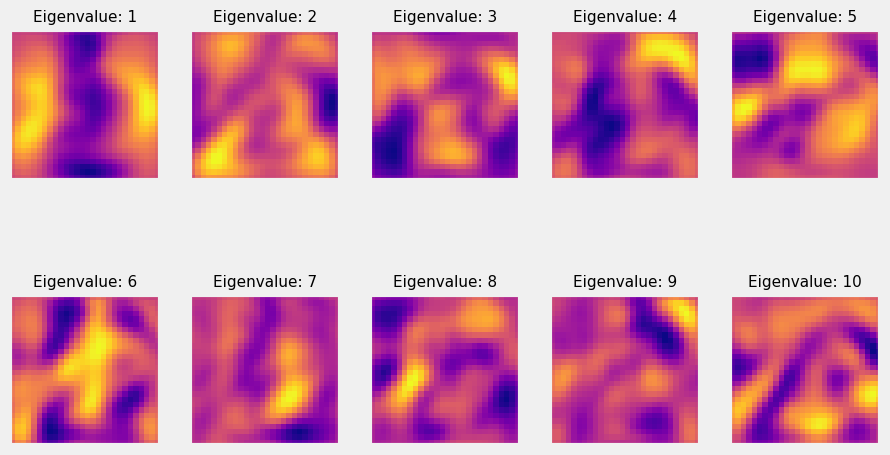

In [ ]:
def plot_pca_eigenvalue(pca_eigenval: np.ndarray,
                        nrow:int = 2, ncol:int = 5
                       ):

    plt.figure(figsize=(10, 6))
    for i in list(range(nrow * ncol)):
        plt.subplot(nrow, ncol, i+1)
        plt.imshow(pca_eigenval[i], cmap='plasma')
        plt.title('Eigenvalue: %s' % str(i+1), size=11)
        plt.xticks([])
        plt.yticks([])
    plt.show()

plot_pca_eigenvalue(pca_eigenvalues_)